<a href="https://colab.research.google.com/github/RomuloPaiva01/Digit-Recognizer/blob/master/digit_rec_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
#importing the dataset from kaggle

df_test2 = pd.read_csv('test.csv')

df_train = pd.read_csv('train.csv')

df_sample = pd.read_csv('sample_submission.csv')

#checking df_test
df_train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
#I want to visualize one of those pictures


#separating the labels
y_train = df_train['label']

#normalizing
df_test2 = df_test2 / 255
df_train = df_train / 255


#getting what is left from the dataset
X_train = df_train.loc[:, ~df_train.columns.isin(['label'])]


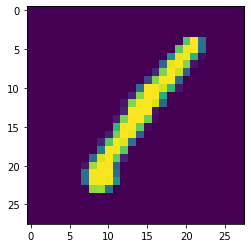

In [4]:
#plotting the first row as an example

#getting only the first row
fig1 = X_train.iloc[0]


#reshaping to a 28x28 image with 1 channel of colors
fig1 = fig1.values.reshape(28,28)

g = plt.imshow(fig1)

In [5]:
X_train

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
#we still need to reshape this dataset into an tensor in order to use the pytorch
X_train = X_train.values.reshape(-1,28,28,1) #28x28 with 1 channel

#transforming into tensors
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train.values)



When using Pythorch, is so much more interesrting to use dataloaedrs, like this one


In [7]:
# Dataset responsible for manipulating data for training as well as training tests.
class DatasetMNIST(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
                
        image = item[1:].values.astype(np.uint8).reshape((28, 28))
        label = item[0]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    

'''

data augmentation test


'''


BATCH_SIZE = 64
VALID_SIZE = 0.20 # percentage of data for validation

transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=(-20, 20)),
    #transforms.RandomHorizontalFlip(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])

transform_valid = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=(-20, 20)),
    #transforms.RandomHorizontalFlip(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])


# Importing data that will be used for training and validation
dataset = pd.read_csv('train.csv')

# Creating datasets for training and validation
train_data = DatasetMNIST(dataset, transform=transform_train)
valid_data = DatasetMNIST(dataset, transform=transform_valid)

# Shuffling data and choosing data that will be used for training and validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(VALID_SIZE * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, sampler=valid_sampler)


print(f"Length train: {len(train_idx)}")
print(f"Length valid: {len(valid_idx)}")

Length train: 33600
Length valid: 8400


In [8]:
# Checking if GPU is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Training on CPU...')
else:
    print('Training on GPU...')

Training on GPU...


In [9]:
#creating first a CNN able to train in this model

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128, 10),
        )
                
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = Net()
print(model)

if train_on_gpu:
    model.cuda()

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.4, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=

In [0]:
#defining the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [11]:
epochs = 100
valid_loss_min = np.Inf
train_losses, valid_losses = [], []
history_accuracy = []

for e in range(1, epochs+1):
    running_loss = 0

    for images, labels in train_loader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # Clear the gradients, do this because gradients are accumulated.
        optimizer.zero_grad()
        
        # Forward pass, get our log-probabilities.
        ps = model(images)

        # Calculate the loss with the logps and the labels.
        loss = criterion(ps, labels)
        
        # Turning loss back.
        loss.backward()
        
        # Take an update step and few the new weights.
        optimizer.step()
        
        running_loss += loss.item()
    else:
        valid_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations.
        with torch.no_grad():
            model.eval() # change the network to evaluation mode
            for images, labels in valid_loader:
                if train_on_gpu:
                    images, labels = images.cuda(), labels.cuda()
                # Forward pass, get our log-probabilities.
                #log_ps = model(images)
                ps = model(images)
                
                # Calculating probabilities for each class.
                #ps = torch.exp(log_ps)
                
                # Capturing the class more likely.
                _, top_class = ps.topk(1, dim=1)
                
                # Verifying the prediction with the labels provided.
                equals = top_class == labels.view(*top_class.shape)
                
                valid_loss += criterion(ps, labels)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        model.train() # change the network to training mode
        
        train_losses.append(running_loss/len(train_loader))
        valid_losses.append(valid_loss/len(valid_loader))
        history_accuracy.append(accuracy/len(valid_loader))
        
        network_learned = valid_loss < valid_loss_min

        if e == 1 or e % 5 == 0 or network_learned:
            print(f"Epoch: {e}/{epochs}.. ",
                  f"Training Loss: {running_loss/len(train_loader):.3f}.. ",
                  f"Validation Loss: {valid_loss/len(valid_loader):.3f}.. ",
                  f"Test Accuracy: {accuracy/len(valid_loader):.3f}")
        
        if network_learned:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), 'model_mtl_mnist.pt')
            print('Detected network improvement, saving current model')



Epoch: 1/100..  Training Loss: 0.502..  Validation Loss: 0.094..  Test Accuracy: 0.971
Detected network improvement, saving current model
Epoch: 2/100..  Training Loss: 0.165..  Validation Loss: 0.065..  Test Accuracy: 0.980
Detected network improvement, saving current model
Epoch: 3/100..  Training Loss: 0.134..  Validation Loss: 0.057..  Test Accuracy: 0.983
Detected network improvement, saving current model
Epoch: 4/100..  Training Loss: 0.114..  Validation Loss: 0.045..  Test Accuracy: 0.985
Detected network improvement, saving current model
Epoch: 5/100..  Training Loss: 0.098..  Validation Loss: 0.047..  Test Accuracy: 0.985
Epoch: 7/100..  Training Loss: 0.087..  Validation Loss: 0.037..  Test Accuracy: 0.989
Detected network improvement, saving current model
Epoch: 9/100..  Training Loss: 0.075..  Validation Loss: 0.035..  Test Accuracy: 0.989
Detected network improvement, saving current model
Epoch: 10/100..  Training Loss: 0.073..  Validation Loss: 0.036..  Test Accuracy: 0.9

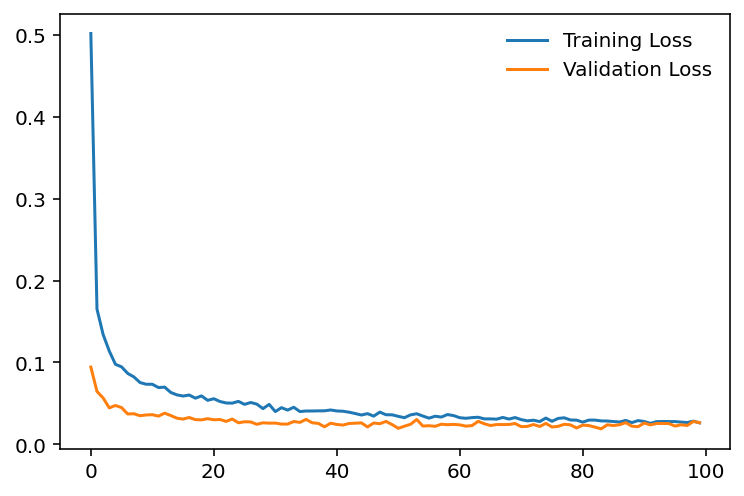

In [12]:
# Viewing training information
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend(frameon=False)



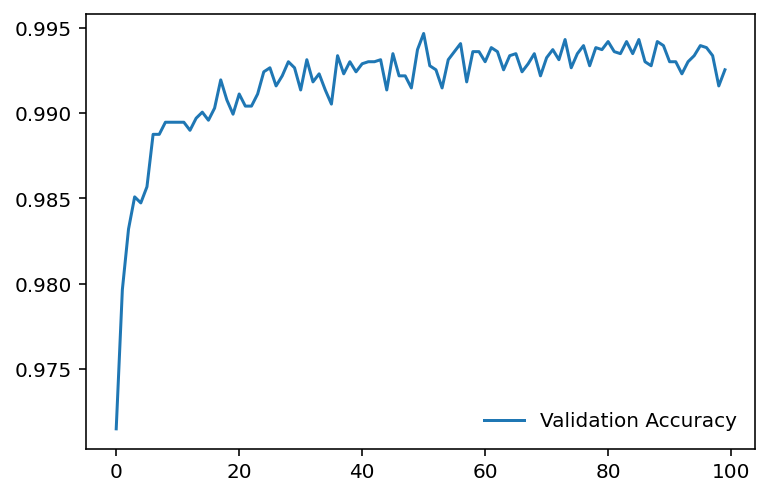

In [13]:
plt.plot(history_accuracy, label='Validation Accuracy')
plt.legend(frameon=False)

In [22]:
# specify the image classes
classes = ['0', '1', '2', '3', '4',
           '5', '6', '7', '8', '9']

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in valid_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target.data)):

        pass

        
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        

      
# average test loss
test_loss = test_loss/len(valid_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %0.4f%% (%2d/%2d)' % (
            classes[i], class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2.2f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.004675

Test Accuracy of     0: 0.9953% (841/845)
Test Accuracy of     1: 0.9947% (947/952)
Test Accuracy of     2: 0.9989% (870/871)
Test Accuracy of     3: 0.9893% (833/842)
Test Accuracy of     4: 0.9922% (767/773)
Test Accuracy of     5: 0.9961% (775/778)
Test Accuracy of     6: 0.9930% (850/856)
Test Accuracy of     7: 0.9908% (861/869)
Test Accuracy of     8: 0.9937% (792/797)
Test Accuracy of     9: 0.9878% (807/817)

Test Accuracy (Overall): 99.32% (8343/8400)


In [18]:
class DatasetSubmissionMNIST(torch.utils.data.Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = self.data.iloc[index].values.astype(np.uint8).reshape((28, 28, 1))

        
        if self.transform is not None:
            image = self.transform(image)
            
        return image
    
    
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

submissionset = DatasetSubmissionMNIST('test.csv', transform=transform)
submissionloader = torch.utils.data.DataLoader(submissionset, batch_size=BATCH_SIZE, shuffle=False)


submission = [['ImageId', 'Label']]

with torch.no_grad():
    model.eval()
    image_id = 1

    for images in submissionloader:
        if train_on_gpu:
            images = images.cuda()
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        
        for prediction in top_class:
            submission.append([image_id, prediction.item()])
            image_id += 1
            
print(len(submission) - 1)

import csv

with open('submission.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerows(submission)
    
print('Submission Complete!')

28000
Submission Complete!
